# Step 4: Data Processing

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ipywidgets as widgets
import plotly.express as px
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer


## Recall of data acquisition and data pre-processing

In [29]:

# Loading the dataset
file_path = "dataset/salaries.csv"  
df = pd.read_csv(file_path)

In [30]:
# Part 1: Data Cleaning

# 1. Check for Duplicates
print("\nChecking for Duplicates...")
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Drop duplicates if any
if num_duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicate rows removed.")
else:
    print("No duplicate rows found.")



# 2. Check for Missing Values
print("\nChecking for Missing Values...")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Imputation or Removal of Missing Values
# Strategy: Drop rows or Impute with mean/median
columns_with_null = missing_values[missing_values > 0].index
for column in columns_with_null:
    if df[column].dtype in ['float64', 'int64']:
        df[column].fillna(df[column].median(), inplace=True)
        print(f"Missing values in '{column}' filled with median.")
    else:
        df[column].fillna(df[column].mode()[0], inplace=True)
        print(f"Missing values in '{column}' filled with mode.")

# Final Check for Missing Values
print("\nFinal Check for Missing Values:")
print(df.isnull().sum())

unique_employee_residence = df['employee_residence'].nunique()
print("Number of unique employee residence:", unique_employee_residence)

unique_job_titles = df['job_title'].nunique()
print("Number of unique job titles:", unique_job_titles)

#Check for negative salaries 
negative_salaries = df[df['salary_in_usd'] < 0]
print("Negative Salaries:")
print(negative_salaries)

#Check for data range Check for salaries outside a specific range
salary_range = (1000, 1000000)
out_of_range_salaries = df[(df['salary_in_usd'] < salary_range[0]) | (df['salary_in_usd'] > salary_range[1])]
print("Out of Range Salaries:")
print(out_of_range_salaries)

# Drop the 'salary' column because we will only use salary_in_usd for this analysis
df = df.drop('salary', axis=1)

# Print the updated DataFrame
df.head()

# Mantieni le prime 15 categorie
top_4_categories = df['employee_residence'].value_counts().head(3).index

df['employee_residence'] = df['employee_residence'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)

# Mantieni le prime 15 categorie
top_4_categories = df['company_location'].value_counts().head(3).index

df['company_location'] = df['company_location'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)

# Mantieni le prime 15 categorie
top_4_categories = df['salary_currency'].value_counts().head(3).index

df['salary_currency'] = df['salary_currency'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)

# Mantieni le prime 15 categorie
top_4_categories = df['employment_type'].value_counts().head(1).index

df['employment_type'] = df['employment_type'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)



Checking for Duplicates...
Number of duplicate rows: 9333
Duplicate rows removed.

Checking for Missing Values...
Series([], dtype: int64)

Final Check for Missing Values:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64
Number of unique employee residence: 79
Number of unique job titles: 254
Negative Salaries:
Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size]
Index: []
Out of Range Salaries:
Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size]
Index: []


## Linear Regression


Pipeline without Data Leakage:


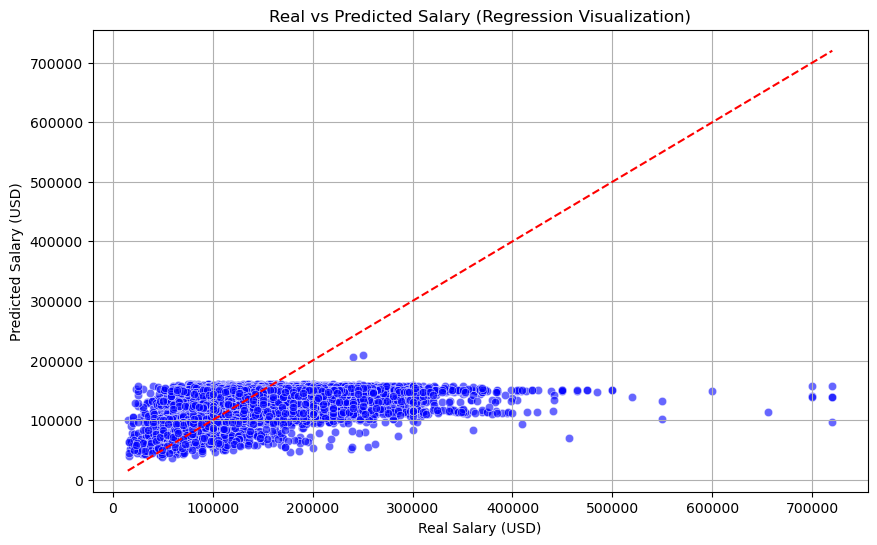


Final Model Evaluation (Without Data Leakage):
{'MAE': 44758.4803590742, 'RMSE': 61631.595988968016, 'R2': 0.11251792582176534}

X_train after preprocessing (first 5 rows):
    0    1    2    3    4    5    6    7    8    9   ...   11   12   13   14  \
0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0   
1  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   
2  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   
3  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0   
4  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0   

    15   16   17     18        19        20  
0  0.0  1.0  2.0  185.0  0.508336 -0.640048  
1  0.0  0.0  2.0  185.0  0.508336 -0.640048  
2  0.0  0.0  2.0  185.0  0.508336 -0.640048  
3  0.0  1.0  2.0  139.0  0.508336 -0.640048  
4  0.0  1.0  2.0  139.0  0.508336 -0.640048  

[5 rows x 21 columns]


In [31]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_true, y_pred, apply_expm1=False):
    if apply_expm1:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Definizione delle feature
low_cardinality_features = ['employment_type', 'company_size', 'employee_residence', 'company_location', 'salary_currency']
high_cardinality_features = ['experience_level', 'job_title']
numerical_features = ['work_year', 'remote_ratio']

# Preprocessing pipelines
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, low_cardinality_features),
        ('oe', oe, high_cardinality_features),
        ('scale', scaler, numerical_features)
    ],
    remainder='passthrough'
)

# Inizializzazione K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)


print("\nPipeline without Data Leakage:")

y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(df):
    X = df.drop('salary_in_usd', axis=1)
    y = np.log1p(df['salary_in_usd'])  # Log-transform sul target
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline_no_leakage = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ])

    pipeline_no_leakage.fit(X_train, y_train)
    y_pred = pipeline_no_leakage.predict(X_test)
    
    y_pred = np.expm1(y_pred)  # Riporta alla scala originale
    y_test = np.expm1(y_test)
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Visualizzazione con Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.6, color='blue')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--')

plt.title("Real vs Predicted Salary (Regression Visualization)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

# Valutazione Finale del Modello
final_results = evaluate_model(np.array(y_true_all), np.array(y_pred_all))
print("\nFinal Model Evaluation (Without Data Leakage):")
print(final_results)
X_train_transformed = preprocessor.fit_transform(X_train)
print("\nX_train after preprocessing (first 5 rows):")
print(pd.DataFrame(X_train_transformed).head())


## Why Linear Regression Performs Poorly on Salary Prediction

## 1. Why Does Linear Regression Perform Poorly?  

### 1.1 Assumption of Linearity in a Non-Linear Problem  
Linear regression assumes a **linear relationship** between the independent variables (features) and the dependent variable (salary). However, salary data often follows **complex non-linear patterns**, influenced by factors such as experience, job title, location, and market conditions.  
- **Evidence from the Plot:**  
  The scatter plot shows that for higher salaries, predictions are **consistently underestimated**. The model struggles to represent extreme values because linear regression cannot model exponential or non-linear growth.  

### 1.2 Outliers and Skewed Distribution  
Salary data frequently contains **extreme outliers** (very high salaries) that distort the model. Linear regression is **highly sensitive to outliers**, which disproportionately affect the regression line.  
- **Result:**  
  The model attempts to minimize overall error but at the cost of accuracy for high salaries, resulting in **low R² and high RMSE**.  

### 1.3 Limited Feature Representation  
The features used (work_year, remote_ratio, etc.) may **not fully capture** the driving factors behind high salaries. Elements like bonuses, stock options, and executive roles might be missing, limiting the model's predictive capacity.  
- **Impact:**  
  Linear regression relies on available features; if high-impact variables are missing, the model cannot generalize effectively.  

### 1.4 Data Imbalance (Bias Toward the Majority Class)  
Most of the data represents salaries in the lower range (<300K). Linear regression primarily fits the **majority class**, neglecting the rare cases of high salaries. This leads to a model that performs well for lower salaries but **fails to capture variance in the upper range**.  

---

## 2. Interpretation of Results  

- **MAE (Mean Absolute Error):** 44,758 USD  
- **RMSE (Root Mean Squared Error):** 61,631 USD  
- **R² (R-Squared):** 0.11  

- **What This Means:**  
  - **High MAE and RMSE** indicate significant average errors, signaling poor performance overall.  
  - **Low R² (0.11)** shows that the model explains **only 11% of the variance** in the data, leaving 89% unexplained. This means the model **barely improves over a simple mean prediction**.  

---

## 3. Why Non-Linear Models (like Random Forest) Perform Better  

- **Non-Linearity:** Models such as **Random Forest** and **XGBoost** can model non-linear relationships and better handle complex interactions.  
- **Robustness to Outliers:** Tree-based models are less sensitive to outliers, providing more stable predictions.  
- **Feature Importance:** Random Forest can dynamically identify feature importance, improving predictive power for high salaries.  

---

## 4. Steps to Improve the Model  

1. **Try Tree-Based Models:** Use Random Forest, XGBoost, or Gradient Boosting to capture non-linear relationships.  
2. **Add Relevant Features:** Introduce variables that better explain high salaries, such as leadership roles, specific years of experience, or company performance.  
3. **Handle Outliers:** Apply **logarithmic transformations** (already used for the target) or use **robust regression techniques** to reduce the influence of outliers.  
4. **Segment the Data:** Train separate models for different salary ranges (e.g., <300K and >300K) to address disparities in patterns.  

While linear regression is useful for simple problems, it **struggles to handle the complexity** of real-world salary data.


## Random Forest


Pipeline without Data Leakage:

Correlazione con il target (salary_in_usd) per fold:
salary_in_usd                    1.000000
ohe__company_size_L              0.016551
oe__experience_level             0.016212
scale__remote_ratio              0.016125
ohe__employment_type_Other       0.010764
ohe__company_location_CA         0.007811
ohe__employee_residence_Other    0.006273
ohe__employee_residence_CA       0.005948
ohe__salary_currency_EUR         0.003827
ohe__company_location_US         0.002372
ohe__salary_currency_Other       0.001500
ohe__salary_currency_USD         0.001210
ohe__company_size_S             -0.000488
ohe__employee_residence_US      -0.001606
oe__job_title                   -0.001753
ohe__company_location_Other     -0.003294
ohe__salary_currency_GBP        -0.006378
ohe__company_location_GB        -0.008525
ohe__employment_type_FT         -0.010764
ohe__employee_residence_GB      -0.011633
ohe__company_size_M             -0.015635
scale__work_year                

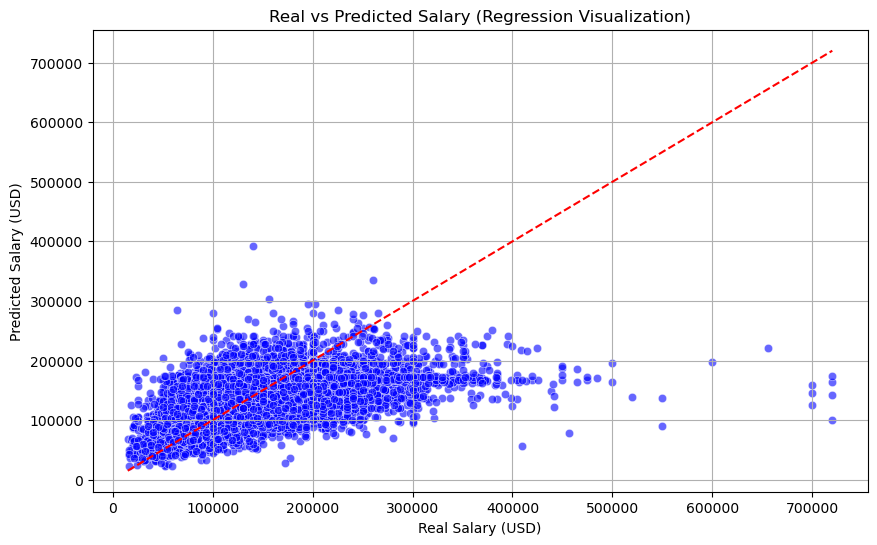


Final Model Evaluation (Without Data Leakage):
{'MAE': 43018.967204679044, 'RMSE': 57973.17517581169, 'R2': 0.21475182497696998}


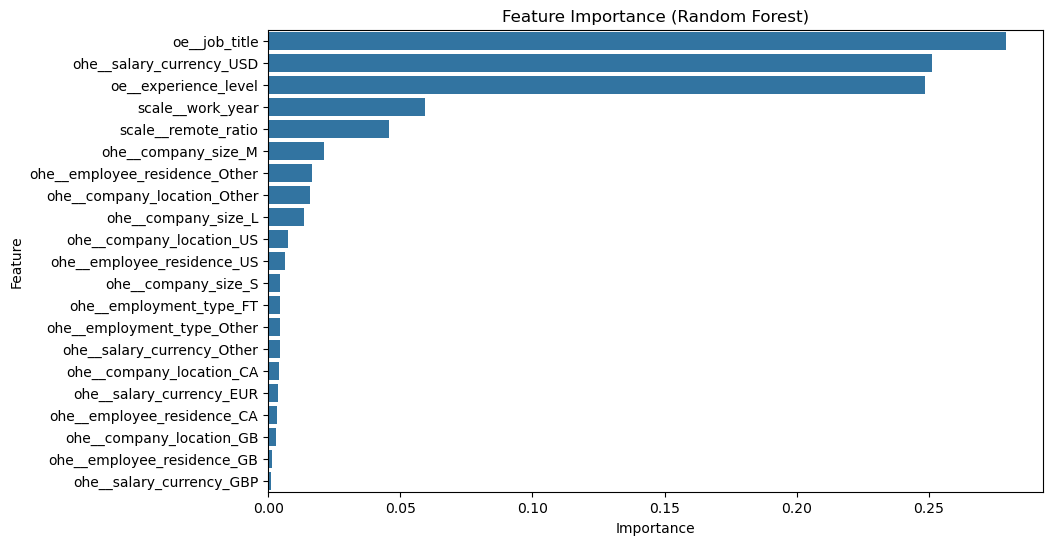

In [32]:

print("\nPipeline without Data Leakage:")

y_true_all = []
y_pred_all = []
feature_importances = []

for train_index, test_index in kf.split(df):
    X = df.drop('salary_in_usd', axis=1)
    y = np.log1p(df['salary_in_usd'])  # Log-transform sul target
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline_no_leakage = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ])

    # Fit della pipeline
    pipeline_no_leakage.fit(X_train, y_train)
    y_pred = pipeline_no_leakage.predict(X_test)
    
    y_pred = np.expm1(y_pred)  # Riporta alla scala originale
    y_test = np.expm1(y_test)
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

    model = pipeline_no_leakage.named_steps['model']
    X_train_transformed = pipeline_no_leakage.named_steps['preprocessor'].transform(X_train)

    X_train_transformed_df = pd.DataFrame(
        X_train_transformed,
        columns=preprocessor.get_feature_names_out()
    )
    X_train_transformed_df['salary_in_usd'] = y_train

    correlation_matrix = X_train_transformed_df.corr(method='pearson')
    target_corr = correlation_matrix['salary_in_usd'].sort_values(ascending=False)
    
    print("\nCorrelazione con il target (salary_in_usd) per fold:")
    print(target_corr)


    feature_importances.append(model.feature_importances_)

# Visualizzazione con Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.6, color='blue')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--')

plt.title("Real vs Predicted Salary (Regression Visualization)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

final_results = evaluate_model(np.array(y_true_all), np.array(y_pred_all))
print("\nFinal Model Evaluation (Without Data Leakage):")
print(final_results)

avg_importance = np.mean(feature_importances, axis=0)
importance_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

# Visualizzazione delle feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance (Random Forest)")
plt.show()




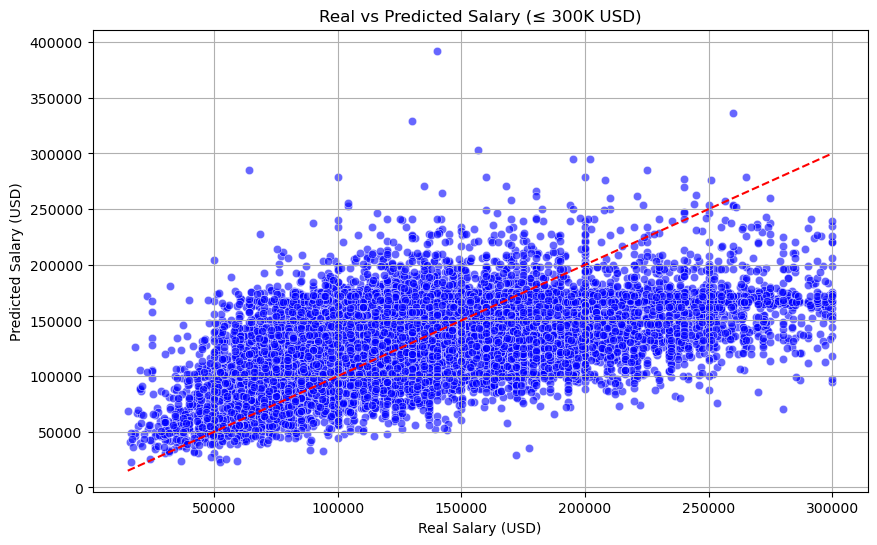

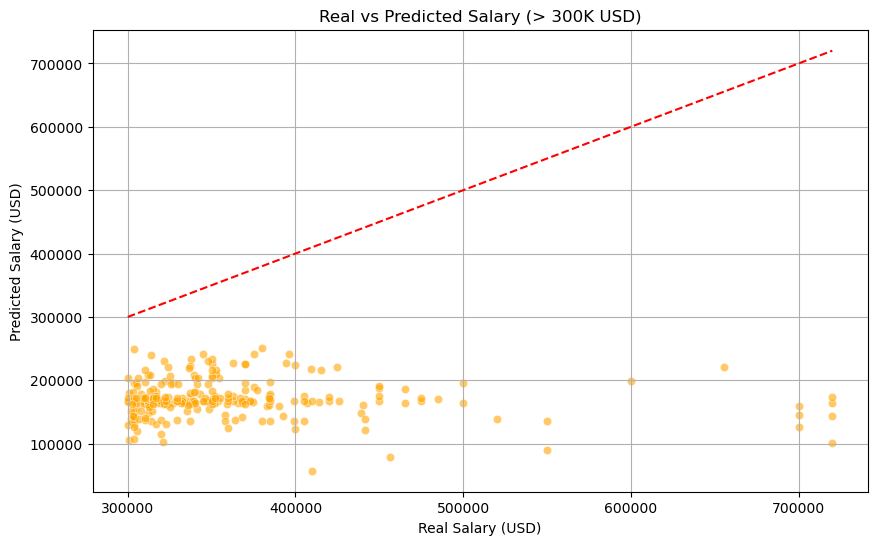


Model Evaluation for Salaries ≤ 300K USD:
{'MAE': 40131.499468832706, 'RMSE': 50633.86005552061, 'R2': 0.21922370162822802}

Model Evaluation for Salaries > 300K USD:
{'MAE': 191649.37164707747, 'RMSE': 210692.01415781223, 'R2': -6.0408770945559525}


In [33]:


y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

mask_low = y_true_all <= 300000
mask_high = y_true_all > 300000

# Salari <= 300.000 USD
y_true_low = y_true_all[mask_low]
y_pred_low = y_pred_all[mask_low]

# Salari > 300.000 USD
y_true_high = y_true_all[mask_high]
y_pred_high = y_pred_all[mask_high]

# Valutazione separata per i due segmenti
results_low = evaluate_model(y_true_low, y_pred_low)
results_high = evaluate_model(y_true_high, y_pred_high)

# Visualizzazione - Salari <= 300.000 USD
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_low, y=y_pred_low, alpha=0.6, color='blue')
plt.plot([min(y_true_low), max(y_true_low)], [min(y_true_low), max(y_true_low)], color='red', linestyle='--')
plt.title("Real vs Predicted Salary (≤ 300K USD)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

# Visualizzazione - Salari > 300.000 USD
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_high, y=y_pred_high, alpha=0.6, color='orange')
plt.plot([min(y_true_high), max(y_true_high)], [min(y_true_high), max(y_true_high)], color='red', linestyle='--')
plt.title("Real vs Predicted Salary (> 300K USD)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

# Stampa delle metriche di valutazione
print("\nModel Evaluation for Salaries ≤ 300K USD:")
print(results_low)

print("\nModel Evaluation for Salaries > 300K USD:")
print(results_high)



## **Motivation for Splitting the Salary Data into Two Ranges**

During the analysis of the regression model results for salary prediction, a significant discrepancy emerged between predictions for **average salaries (≤ 300K USD)** and **high salaries (> 300K USD)**.  
This discrepancy highlighted that the model struggles to accurately predict extreme values.  

**Reasons for Splitting the Data:**
1. **Non-Linear Distribution of Salaries:**  
   Salary distributions are often skewed, with a large concentration of values in the lower to mid-range and fewer high-end salaries. This imbalance causes the model to generalize better for common salary ranges but poorly for rarer, higher salaries.  

2. **Model Bias Toward Majority Data:**  
   Most of the data falls below 300K USD, leading the model to optimize for this range. As a result, predictions for high salaries are systematically underestimated because the model cannot capture the patterns of this smaller subset.

3. **Distinct Patterns in High Salaries:**  
   Higher salaries (> 300K USD) may be influenced by factors that are not as relevant for lower salaries, such as executive positions, equity, or bonuses. A single model may not be flexible enough to account for these diverse influences.

---

## **Analysis of Results**

### **Evaluation for Salaries ≤ 300K USD:**  
- **Mean Absolute Error (MAE):** 40,131 USD  
- **Root Mean Squared Error (RMSE):** 50,633 USD  
- **R² Score:** 0.22  

**Interpretation:**  
The model performs reasonably well for salaries below 300K USD. The R² score, while not exceptionally high, indicates that the model captures some variance in the data. However, the error remains relatively high, suggesting there is room for improvement in predicting even the average salaries.

---

### **Evaluation for Salaries > 300K USD:**  
- **Mean Absolute Error (MAE):** 191,649 USD  
- **Root Mean Squared Error (RMSE):** 210,692 USD  
- **R² Score:** -6.04  

**Interpretation:**  
The model performs extremely poorly for high salaries. The **negative R² score** indicates that the model is worse than a simple mean baseline prediction. This suggests that the model fails to capture the underlying patterns for high-end salaries, leading to large prediction errors.

---

## **Why Does the Model Perform Poorly for Salaries Above 300K?**

1. **Lack of Sufficient Data Points:**  
   The number of data points for salaries above 300K USD is small compared to lower salaries, making it difficult for the model to learn the relevant patterns.

2. **Overfitting to Majority Class:**  
   The model overfits to the majority of the data (≤ 300K USD), neglecting the characteristics of the high-salary segment.

3. **Limited Feature Representation:**  
   Some features that drive high salaries may not be adequately represented in the dataset, limiting the model's ability to predict large values.



## Feature Selection


Feature Importance (Random Forest):
                          Feature  Importance
18                  oe__job_title    0.278925
17           oe__experience_level    0.249378
16       ohe__salary_currency_USD    0.248121
19               scale__work_year    0.060321
20            scale__remote_ratio    0.046061
11    ohe__company_location_Other    0.022695
3             ohe__company_size_M    0.021908
2             ohe__company_size_L    0.014274
7   ohe__employee_residence_Other    0.013518
12       ohe__company_location_US    0.006414
8      ohe__employee_residence_US    0.006200
1      ohe__employment_type_Other    0.004570
0         ohe__employment_type_FT    0.004422
13       ohe__salary_currency_EUR    0.004127
4             ohe__company_size_S    0.003969
15     ohe__salary_currency_Other    0.003872
9        ohe__company_location_CA    0.003587
5      ohe__employee_residence_CA    0.003466
10       ohe__company_location_GB    0.001885
6      ohe__employee_residence_GB    0.0014

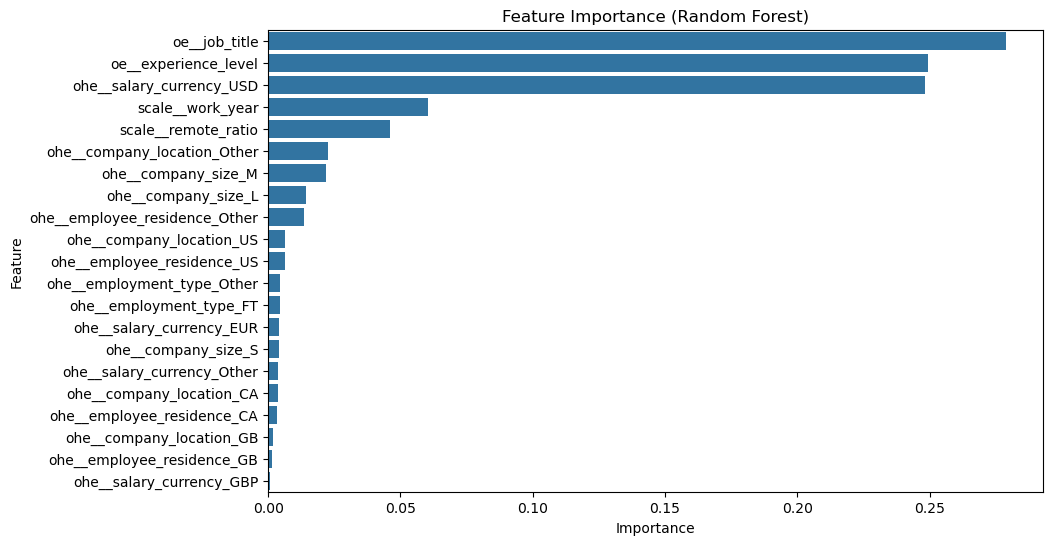


Permutation Importance:
                     Feature    Importance
17          experience_level  2.587311e-06
18                 job_title  2.153900e-06
16       salary_currency_USD  1.562721e-06
11    company_location_Other  5.535015e-07
19                 work_year  2.035204e-07
8      employee_residence_US  1.718841e-07
20              remote_ratio  1.377362e-07
13       salary_currency_EUR  1.155201e-07
4             company_size_S  4.675222e-08
3             company_size_M  4.013610e-08
7   employee_residence_Other  3.610194e-08
9        company_location_CA  1.200174e-08
10       company_location_GB  9.712022e-09
5      employee_residence_CA  8.011520e-09
2             company_size_L  5.181434e-09
15     salary_currency_Other  4.580962e-09
12       company_location_US  4.338331e-09
0         employment_type_FT  9.307395e-10
1      employment_type_Other -1.140657e-09
6      employee_residence_GB -1.095577e-08
14       salary_currency_GBP -1.500965e-08


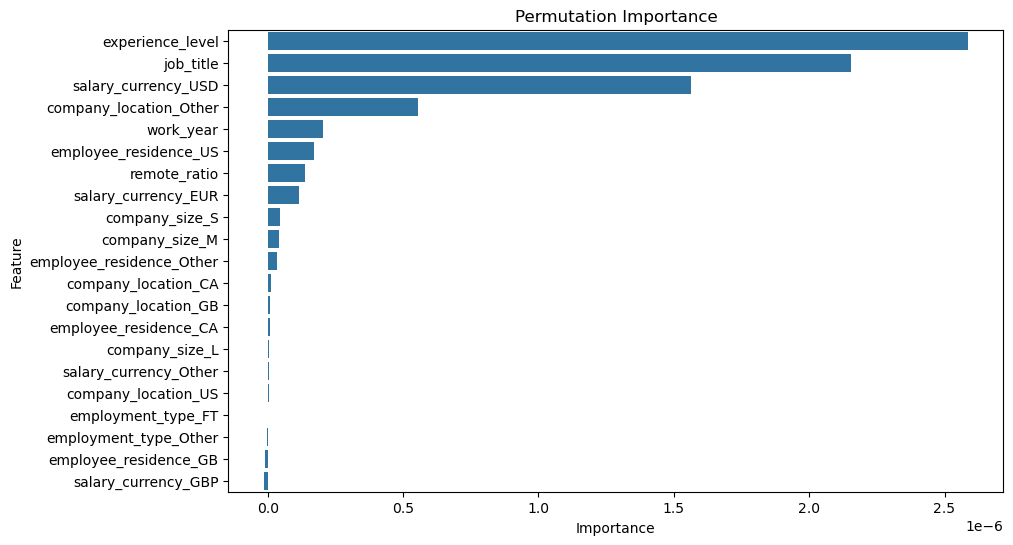

In [ ]:
from sklearn.inspection import permutation_importance
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

if isinstance(pipeline_no_leakage.named_steps['model'], RandomForestRegressor):
    feature_importance = pipeline_no_leakage.named_steps['model'].feature_importances_
    feature_names = preprocessor.get_feature_names_out()

   
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importance (Random Forest):")
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title("Feature Importance (Random Forest)")
    plt.show()


elif isinstance(pipeline_no_leakage.named_steps['model'], LinearRegression):
    coefficients = pipeline_no_leakage.named_steps['model'].coef_
    feature_names = preprocessor.get_feature_names_out()

    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)

    print("\nFeature Coefficients (Linear Regression):")
    print(coef_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title("Feature Coefficients (Linear Regression)")
    plt.show()



X_test_transformed = preprocessor.transform(X_test)

perm_importance = permutation_importance(
    pipeline_no_leakage['model'],  # Considera solo il modello dalla pipeline
    X_test_transformed,
    y_test,
    n_repeats=10,
    random_state=42
)

# Estrai i nomi delle feature preprocessate
encoded_columns = preprocessor.named_transformers_['ohe'].get_feature_names_out(low_cardinality_features)
ordinal_columns = high_cardinality_features
scaled_columns = numerical_features
feature_names = np.concatenate([encoded_columns, ordinal_columns, scaled_columns])

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance:")
print(perm_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_df)
plt.title("Permutation Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()



## Explainable Artificial Intelligence XAI

In [35]:
#================================
# 4. SHAP (SHapley Additive Explanations)
# ================================
print("\nRunning SHAP Analysis...")

# Crea un explainer SHAP
explainer = shap.Explainer(pipeline_no_leakage.named_steps['model'], X_test_transformed)
shap_values = explainer(X_test_transformed)

# Visualizza il summary plot di SHAP
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

# SHAP Force Plot (singola predizione)
plt.figure()
shap.force_plot(
    explainer.expected_value,
    shap_values.values[0],  # Usa .values per ottenere i valori corretti
    features=X_test_transformed[0],  # Passa le feature corrette
    feature_names=feature_names,
    matplotlib=True
)

# plt.title("SHAP Force Plot (First Prediction)")
# plt.show()

# ================================
# 5. LIME (Local Interpretable Model-agnostic Explanations)
# ================================
print("\nRunning LIME Analysis...")

# Crea un explainer LIME
explainer_lime = LimeTabularExplainer(
    training_data=X_test_transformed,
    mode='regression',
    feature_names=feature_names,
    discretize_continuous=True
)

# Esegui LIME per una predizione (prendiamo la prima istanza di test)
i = 0
exp = explainer_lime.explain_instance(X_test_transformed[i], 
                                      pipeline_no_leakage.named_steps['model'].predict)

# Visualizza la spiegazione LIME
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
plt.title("LIME Explanation (First Prediction)")
plt.show()

### Recursive Feature Elimination


Pipeline with RFE (Recursive Feature Elimination):

Selected Features by RFE:
['ohe__salary_currency_USD' 'ohe__company_location_Other'
 'ohe__company_location_US' 'ohe__company_size_L' 'ohe__company_size_M'
 'ohe__employee_residence_Other' 'oe__experience_level' 'oe__job_title'
 'scale__work_year' 'scale__remote_ratio']

Selected Features by RFE:
['ohe__salary_currency_USD' 'ohe__company_location_Other'
 'ohe__company_location_US' 'ohe__company_size_L' 'ohe__company_size_M'
 'ohe__employee_residence_Other' 'oe__experience_level' 'oe__job_title'
 'scale__work_year' 'scale__remote_ratio']

Selected Features by RFE:
['ohe__salary_currency_USD' 'ohe__company_location_Other'
 'ohe__company_location_US' 'ohe__company_size_L' 'ohe__company_size_M'
 'ohe__employee_residence_Other' 'oe__experience_level' 'oe__job_title'
 'scale__work_year' 'scale__remote_ratio']

Selected Features by RFE:
['ohe__salary_currency_USD' 'ohe__company_location_Other'
 'ohe__company_location_US' 'ohe__company_size_

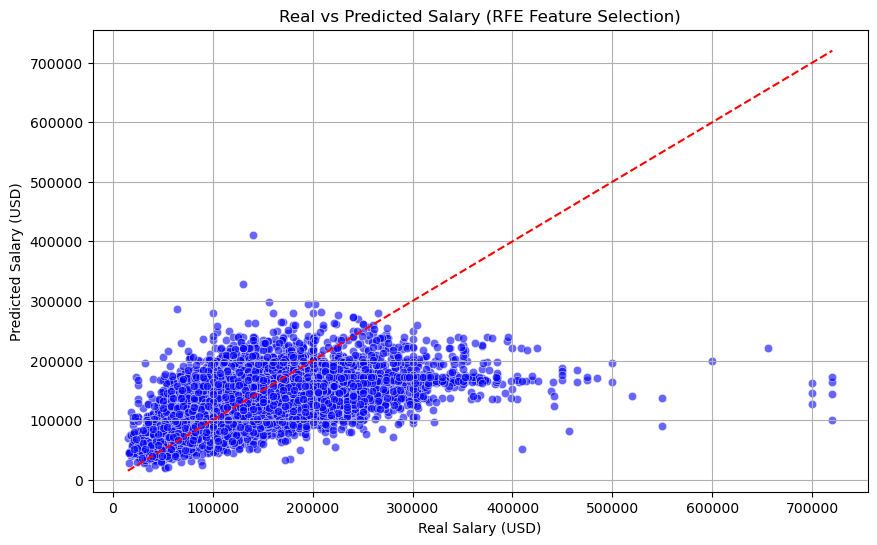


Final Model Evaluation (With RFE Feature Selection):
{'MAE': 43050.37519280443, 'RMSE': 58005.05970905481, 'R2': 0.21388783377550946}


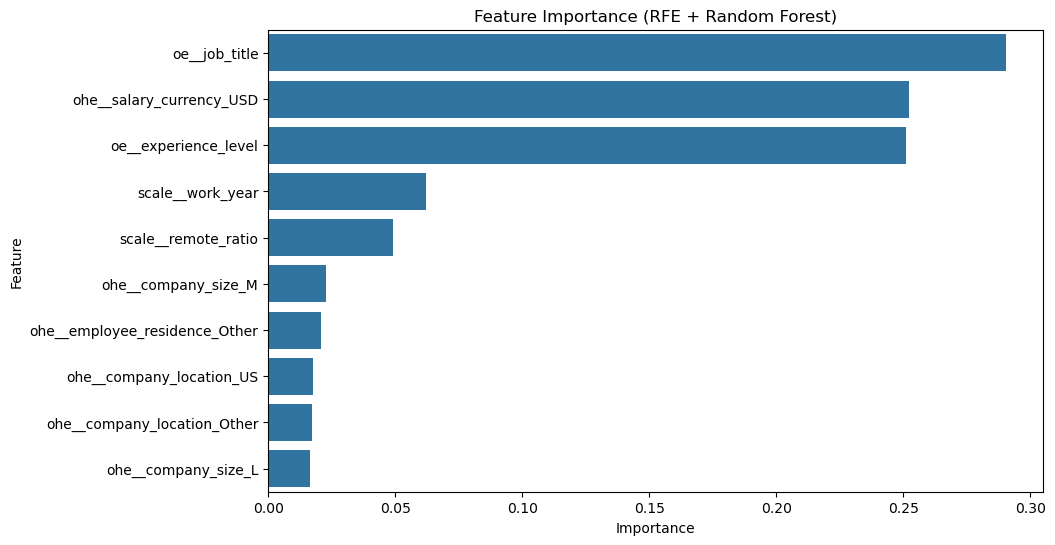

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


low_cardinality_features = ['employment_type', 'company_size', 'employee_residence', 'company_location', 'salary_currency']
high_cardinality_features = ['experience_level', 'job_title']
numerical_features = ['work_year', 'remote_ratio']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, ['salary_currency', 'company_location', 'company_size', 'employment_type','employee_residence']),
        ('oe', oe, ['experience_level', 'job_title']),
        ('scale', scaler, ['work_year', 'remote_ratio'])
    ],
    remainder='passthrough'  # Mantiene le altre feature
)



base_model = RandomForestRegressor(random_state=42, n_estimators=300)
pipeline_no_leakage = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', base_model)
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)


print("\nPipeline with RFE (Recursive Feature Elimination):")

y_true_all = []
y_pred_all = []
feature_importances = []

for train_index, test_index in kf.split(df):
    X = df.drop('salary_in_usd', axis=1)
    y = np.log1p(df['salary_in_usd'])  # Log-transform sul target
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    preprocessor.fit(X_train)
    feature_names = preprocessor.get_feature_names_out()

    X_train_transformed = preprocessor.transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    # ===========================
    # RFE per la Selezione delle Feature
    # ===========================
    selector = RFE(estimator=base_model, n_features_to_select=10)  # Seleziona le 10 migliori feature
    selector.fit(X_train_transformed, y_train)

    selected_features_mask = selector.support_
    selected_features = feature_names[selected_features_mask]
    print("\nSelected Features by RFE:")
    print(selected_features)

    X_train_filtered = X_train_transformed[:, selected_features_mask]
    X_test_filtered = X_test_transformed[:, selected_features_mask]
    
    pipeline_no_leakage.named_steps['model'].fit(X_train_filtered, y_train)
    y_pred = pipeline_no_leakage.named_steps['model'].predict(X_test_filtered)
    
    y_pred = np.expm1(y_pred)  # Riporta alla scala originale
    y_test = np.expm1(y_test)
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

    # Salva l'importanza delle feature selezionate
    feature_importances.append(pipeline_no_leakage.named_steps['model'].feature_importances_)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.6, color='blue')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--')

plt.title("Real vs Predicted Salary (RFE Feature Selection)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

final_results = {
    "MAE": mean_absolute_error(y_true_all, y_pred_all),
    "RMSE": np.sqrt(mean_squared_error(y_true_all, y_pred_all)),
    "R2": r2_score(y_true_all, y_pred_all)
}
print("\nFinal Model Evaluation (With RFE Feature Selection):")
print(final_results)


avg_importance = np.mean(feature_importances, axis=0)
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance (RFE + Random Forest)")
plt.show()


## Hyperparameter Tuning with Random Forest and RandomizedSearchCV

##### RandomForestRegressor has many parameters (number of trees, max depth, number of features) that directly affect performance. Manual selection does not guarantee the best result.

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters Found:
{'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': 20}


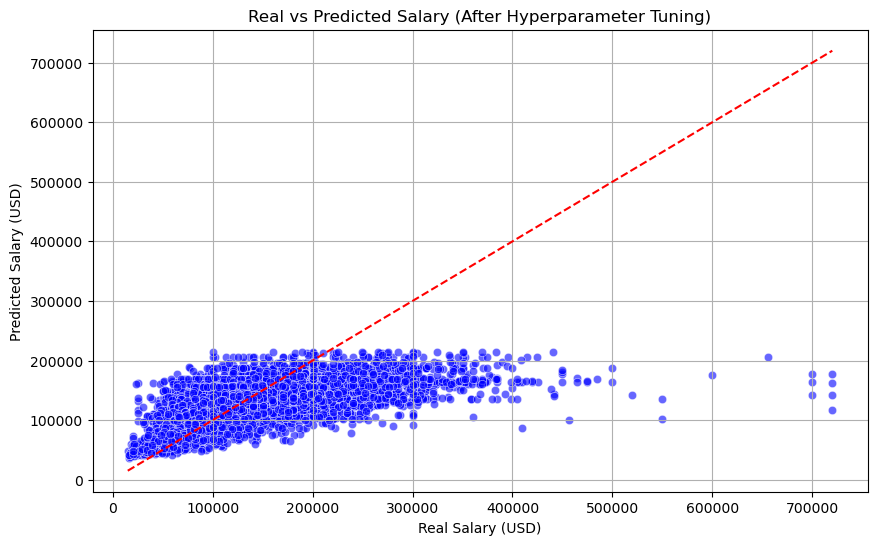


Model Evaluation (After Hyperparameter Tuning):
{'MAE': 40059.88157730346, 'RMSE': 55248.17533325764, 'R2': 0.2868372682977637}


In [37]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Definizione delle Feature
low_cardinality_features = ['employment_type', 'company_size', 'employee_residence', 'company_location', 'salary_currency']
high_cardinality_features = ['experience_level', 'job_title']
numerical_features = ['work_year', 'remote_ratio']

# 2. Preprocessing Pipeline
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, low_cardinality_features),
        ('oe', oe, high_cardinality_features),
        ('scale', scaler, numerical_features)
    ],
    remainder='passthrough'
)

# 3. Random Forest Hyperparameter Grid
param_grid = {
    'model__n_estimators': [100, 200, 300, 400], #numero di alberi
    'model__max_depth': [10, 20, 30, 50, None], #profondità dell'albero
    'model__min_samples_split': [2, 5, 10], #numero minimo di campioni richiesti per dividere un nodo
    'model__min_samples_leaf': [1, 2, 4], #numero minimo di campioni richiesti per essere in un nodo foglia
    'model__max_features': ['sqrt', 'log2']#numero di feature da considerare per la migliore divisione
}

# 4. Inizializzazione della Pipeline
pipeline_no_leakage = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# 5. RandomizedSearchCV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=pipeline_no_leakage,
    param_distributions=param_grid,
    n_iter=20,  # Numero di iterazioni casuali per cercare gli iperparametri
    cv=kf,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_squared_error' # viene minimizzato l'errore quadratico medio (MSE).
)

# 6. Validazione Cross-Validation
X = df.drop('salary_in_usd', axis=1)
y = np.log1p(df['salary_in_usd'])  # Log-transform per il target

random_search.fit(X, y)

# 7. Miglior Modello e Parametri
best_model = random_search.best_estimator_
print("\nBest Parameters Found:")
print(random_search.best_params_)

# 8. Predizione e Valutazione del Miglior Modello
y_pred_all = np.expm1(best_model.predict(X))  # Inverso del log1p
y_true_all = df['salary_in_usd']

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.6, color='blue')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--')
plt.title("Real vs Predicted Salary (After Hyperparameter Tuning)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

final_results = {
    "MAE": mean_absolute_error(y_true_all, y_pred_all),
    "RMSE": np.sqrt(mean_squared_error(y_true_all, y_pred_all)),
    "R2": r2_score(y_true_all, y_pred_all)
}
print("\nModel Evaluation (After Hyperparameter Tuning):")
print(final_results)




In [38]:
%conda install -c conda-forge xgboost


Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 24.11.3

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## Hyperparameter Tuning with XGBoost and RandomizedSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters Found:
{'model__subsample': 0.7, 'model__n_estimators': 200, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__gamma': 0.1, 'model__colsample_bytree': 0.7}


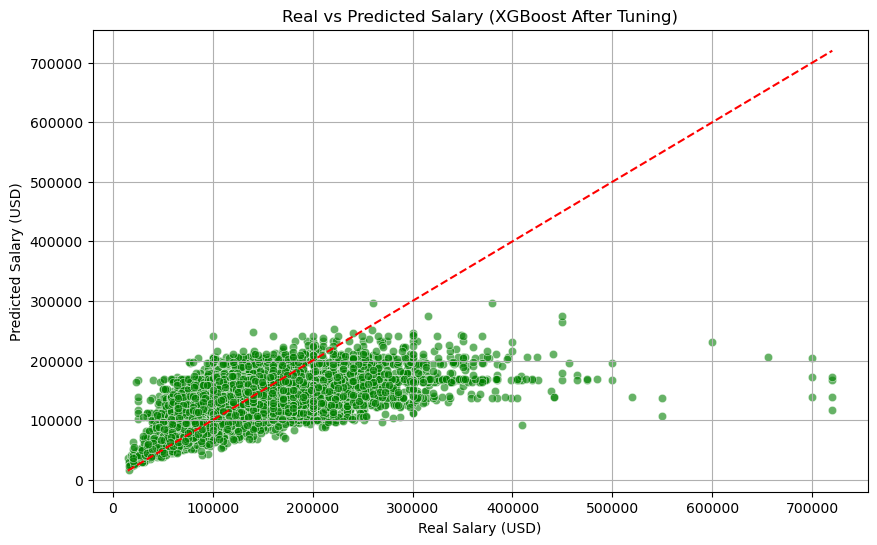


Model Evaluation (XGBoost After Tuning):
{'MAE': 39596.65012051823, 'RMSE': 54534.40844690949, 'R2': 0.30514534002012506}


In [39]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Definizione delle Feature
low_cardinality_features = ['employment_type', 'company_size', 'employee_residence', 'company_location', 'salary_currency']
high_cardinality_features = ['experience_level', 'job_title']
numerical_features = ['work_year', 'remote_ratio']

# 2. Preprocessing Pipeline
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, low_cardinality_features),
        ('oe', oe, high_cardinality_features),
        ('scale', scaler, numerical_features)
    ],
    remainder='passthrough'
)

# 3. Hyperparameter Grid per XGBoost
param_grid = {
    'model__n_estimators': [100, 200, 300], #numero di alberi
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2], #tasso di apprendimento (più basso = convergenza più lenta ma accurata).
    'model__max_depth': [3, 6, 10], # Profondità massima degli alberi (più alto = rischio overfitting).
    'model__subsample': [0.7, 0.8, 1.0], # Percentuale di campioni da utilizzare per addestrare ciascun albero.
    'model__colsample_bytree': [0.7, 0.8, 1.0], # Percentuale di feature da utilizzare per addestrare ciascun albero.
    'model__gamma': [0, 0.1, 0.3, 0.5] #Penalità di potatura (più alto = alberi meno complessi).
}

# 4. Pipeline con XGBoost
pipeline_no_leakage = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# 5. RandomizedSearchCV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=pipeline_no_leakage,
    param_distributions=param_grid,
    n_iter=20,
    cv=kf,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# 6. Validazione e Addestramento
X = df.drop('salary_in_usd', axis=1)
y = np.log1p(df['salary_in_usd'])  # Log-transform per il target

random_search.fit(X, y)

# 7. Miglior Modello e Parametri
best_model = random_search.best_estimator_
print("\nBest Parameters Found:")
print(random_search.best_params_)

# 8. Predizione e Valutazione del Modello
y_pred_all = np.expm1(best_model.predict(X))
y_true_all = df['salary_in_usd']

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.6, color='green')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--')
plt.title("Real vs Predicted Salary (XGBoost After Tuning)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

final_results = {
    "MAE": mean_absolute_error(y_true_all, y_pred_all),
    "RMSE": np.sqrt(mean_squared_error(y_true_all, y_pred_all)),
    "R2": r2_score(y_true_all, y_pred_all)
}
print("\nModel Evaluation (XGBoost After Tuning):")
print(final_results)


## Split salary


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=400, model__subsample=0.8; total time=   0.0s
[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=400, model__subsample=0.8; total time=   0.0s
[CV] END model__colsample_bytree=1.0, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=400, model__subsample=0.8; total time=   0.0s
[CV] END model__colsample_bytree=1.0, model__gamma=0.1, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=400, model__subsample=1.0; total time=   0.0s
[CV] END model__colsample_bytree=0.7, model__gamma=0.3, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=400, model__subsample=0.7; total time=   0.0s
[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.01, model__

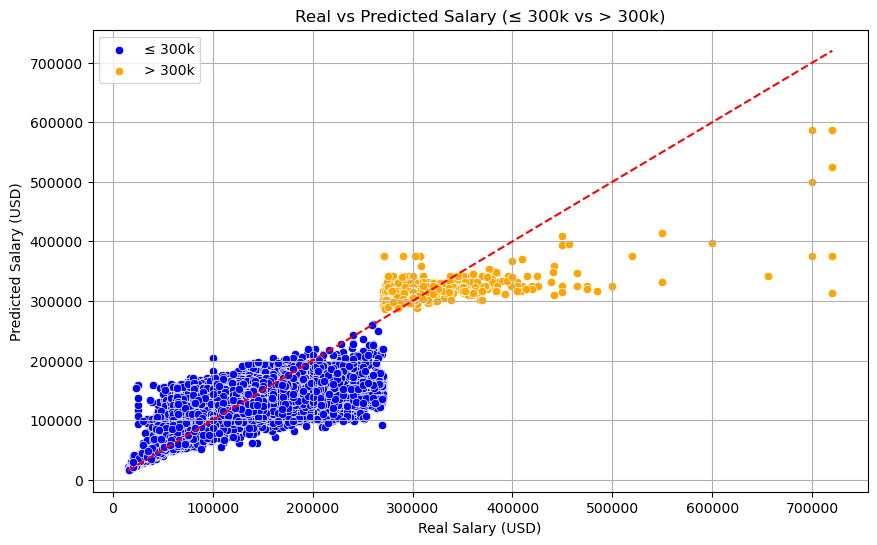


Model Evaluation (≤ 300k):
{'MAE': 34043.128011226916, 'RMSE': 43651.7595057678, 'R2': 0.34881961050616817}

Model Evaluation (> 300k):
{'MAE': 34270.68599094566, 'RMSE': 54747.91269504631, 'R2': 0.36954822509458196}


In [40]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dividi i Dati in base al Salario
df_below_300k = df[df['salary_in_usd'] <= 300000]
df_above_300k = df[df['salary_in_usd'] > 300000]

# 2. Prepara i Dataset
X_below = df_below_300k.drop('salary_in_usd', axis=1)
y_below = np.log1p(df_below_300k['salary_in_usd'])  # Applichiamo log1p per stabilizzare
X_above = df_above_300k.drop('salary_in_usd', axis=1)
y_above = np.log1p(df_above_300k['salary_in_usd'])

# 3. Definizione del Preprocessing Pipeline
low_cardinality_features = ['employment_type', 'company_size', 'employee_residence', 'company_location', 'salary_currency']
high_cardinality_features = ['experience_level', 'job_title']
numerical_features = ['work_year', 'remote_ratio']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, low_cardinality_features),
        ('oe', oe, high_cardinality_features),
        ('scale', scaler, numerical_features)
    ],
    remainder='passthrough'  
)

# 4. Pipeline per Salari ≤ 300k (Modello più semplice senza tuning)
pipeline_below = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# 5. Addestramento del Modello per Salari ≤ 300k
pipeline_below.fit(X_below, y_below)

# 6. Modello per Salari > 300k (Focus su Hyperparameter Tuning)
param_grid_above = {
    'model__n_estimators': [200, 300, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [6, 10, 15],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.3]
}

pipeline_above = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

kf = KFold(n_splits=3, shuffle=True, random_state=42)
random_search_above = RandomizedSearchCV(
    estimator=pipeline_above,
    param_distributions=param_grid_above,
    n_iter=15,
    cv=kf,
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# 7. Addestramento e Ricerca Iperparametri per Salari > 300k
random_search_above.fit(X_above, y_above)
best_model_above = random_search_above.best_estimator_

# 8. Valutazione e Predizione
y_pred_above = np.expm1(best_model_above.predict(X_above))
y_pred_below = np.expm1(pipeline_below.predict(X_below))

# 9. Visualizzazione dei Risultati
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_below_300k['salary_in_usd'], y=y_pred_below, color='blue', label='≤ 300k')
sns.scatterplot(x=df_above_300k['salary_in_usd'], y=y_pred_above, color='orange', label='> 300k')
plt.plot([min(df['salary_in_usd']), max(df['salary_in_usd'])], 
         [min(df['salary_in_usd']), max(df['salary_in_usd'])], color='red', linestyle='--')
plt.title("Real vs Predicted Salary (≤ 300k vs > 300k)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.legend()
plt.show()

# 10. Metriche Separate (Salari ≤ 300k e > 300k)
results_above = {
    "MAE": mean_absolute_error(np.expm1(y_above), y_pred_above),
    "RMSE": np.sqrt(mean_squared_error(np.expm1(y_above), y_pred_above)),
    "R2": r2_score(np.expm1(y_above), y_pred_above)
}

results_below = {
    "MAE": mean_absolute_error(np.expm1(y_below), y_pred_below),
    "RMSE": np.sqrt(mean_squared_error(np.expm1(y_below), y_pred_below)),
    "R2": r2_score(np.expm1(y_below), y_pred_below)
}

print("\nModel Evaluation (≤ 300k):")
print(results_below)

print("\nModel Evaluation (> 300k):")
print(results_above)


## Data Validation

In [41]:
from scipy.stats import ttest_rel, wilcoxon
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np


ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, low_cardinality_features),
        ('oe', oe, high_cardinality_features),
        ('scale', scaler, numerical_features)
    ],
    remainder='passthrough'
)


linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

random_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

xgboost_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])



kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scorer(mean_squared_error, greater_is_better=False)  # Minimizziamo RMSE


linear_scores = np.sqrt(-cross_val_score(linear_model, X, y, cv=kf, scoring=scoring))
rf_scores = np.sqrt(-cross_val_score(random_forest_model, X, y, cv=kf, scoring=scoring))
xgb_scores = np.sqrt(-cross_val_score(xgboost_model, X, y, cv=kf, scoring=scoring))


# Test Statistico (t-test o Wilcoxon)

print("\nModel Comparison - Paired t-test or Wilcoxon Test:")

# Confronto tra Linear Regression e Random Forest
t_stat, p_value_t_lr_rf = ttest_rel(linear_scores, rf_scores)
w_stat, p_value_w_lr_rf = wilcoxon(linear_scores, rf_scores)
print(f"Linear Regression vs Random Forest - t-test p-value: {p_value_t_lr_rf:.4f}")
print(f"Linear Regression vs Random Forest - Wilcoxon p-value: {p_value_w_lr_rf:.4f}")

# Confronto tra Linear Regression e XGBoost
t_stat, p_value_t_lr_xgb = ttest_rel(linear_scores, xgb_scores)
w_stat, p_value_w_lr_xgb = wilcoxon(linear_scores, xgb_scores)
print(f"Linear Regression vs XGBoost - t-test p-value: {p_value_t_lr_xgb:.4f}")
print(f"Linear Regression vs XGBoost - Wilcoxon p-value: {p_value_w_lr_xgb:.4f}")

# Confronto tra Random Forest e XGBoost
t_stat, p_value_t_rf_xgb = ttest_rel(rf_scores, xgb_scores)
w_stat, p_value_w_rf_xgb = wilcoxon(rf_scores, xgb_scores)
print(f"Random Forest vs XGBoost - t-test p-value: {p_value_t_rf_xgb:.4f}")
print(f"Random Forest vs XGBoost - Wilcoxon p-value: {p_value_w_rf_xgb:.4f}")




Model Comparison - Paired t-test or Wilcoxon Test:
Linear Regression vs Random Forest - t-test p-value: 0.0001
Linear Regression vs Random Forest - Wilcoxon p-value: 0.0625
Linear Regression vs XGBoost - t-test p-value: 0.0000
Linear Regression vs XGBoost - Wilcoxon p-value: 0.0625
Random Forest vs XGBoost - t-test p-value: 0.0024
Random Forest vs XGBoost - Wilcoxon p-value: 0.0625
